In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import warnings

/home-3/pravich2@jhu.edu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
warnings.filterwarnings('ignore')
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1


In [3]:
adata = sc.read("../data/counts.tsv", cache=True, var_names='gene_ids')
adata = adata.transpose()

... reading from cache file cache/..-data-counts.h5ad


In [4]:
datDir = "/work-zfs/abattle4/prashanthi/project/sc_endo_diff/"
metaDataFile = datDir + "cell_metadata_cols.tsv"
metaData = pd.read_csv(metaDataFile, sep='\t')
adata.obs = metaData

... storing 'auxDir' as categorical
... storing 'day' as categorical
... storing 'donor' as categorical
... storing 'expected_format' as categorical
... storing 'experiment' as categorical
... storing 'library_types' as categorical
... storing 'libType' as categorical
... storing 'mapping_type' as categorical
... storing 'salmon_version' as categorical
... storing 'samp_type' as categorical
... storing 'start_time' as categorical
... storing 'well_id' as categorical
... storing 'well_type' as categorical
... storing 'donor_short_id' as categorical
... storing 'donor_long_id' as categorical


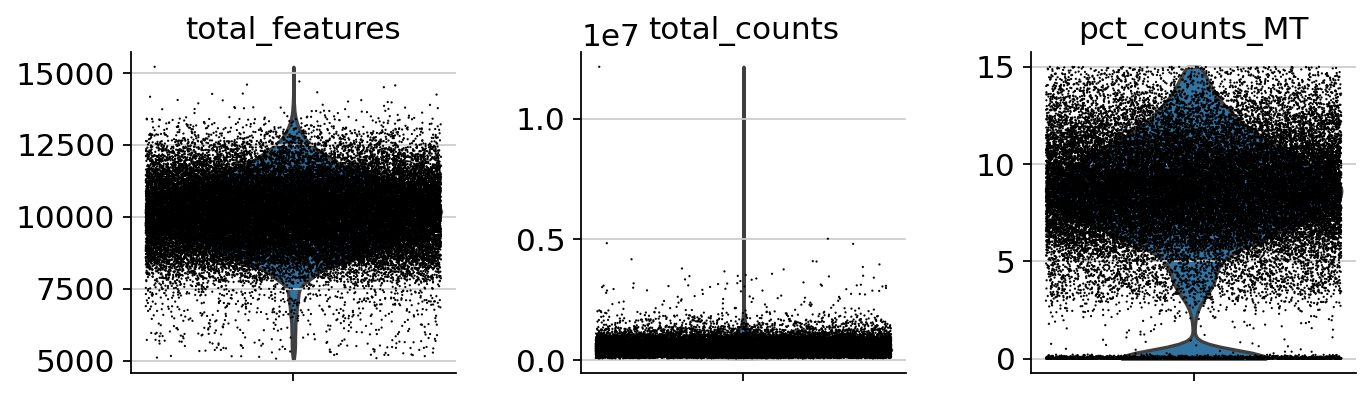

In [5]:
sc.pl.violin(adata, ['total_features', 'total_counts', 'pct_counts_MT'],
             jitter=0.4, multi_panel=True, verbose = False)

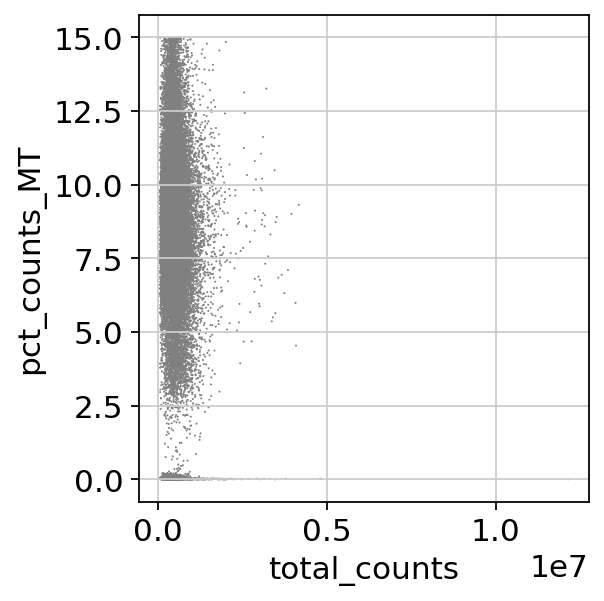

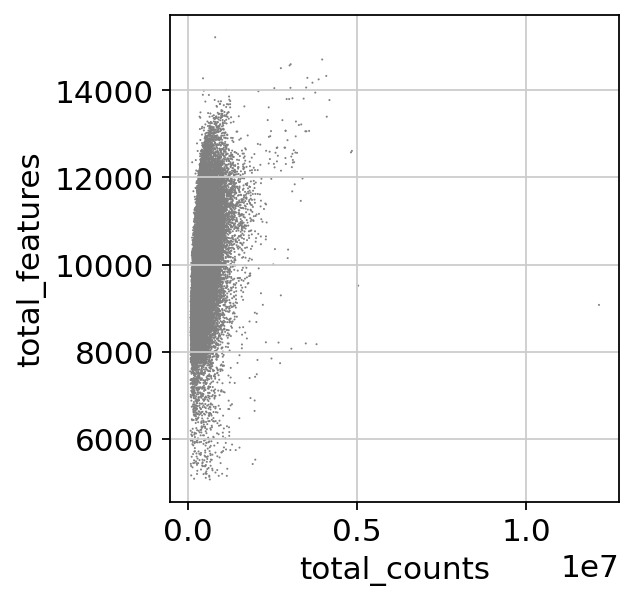

In [6]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='total_features')

extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


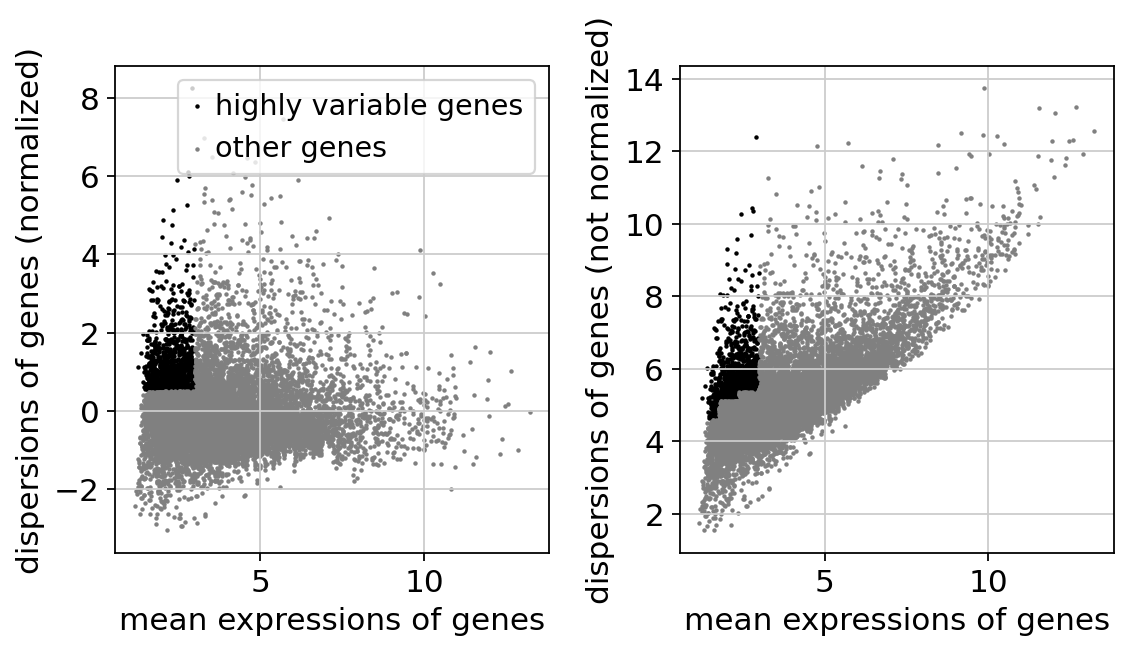

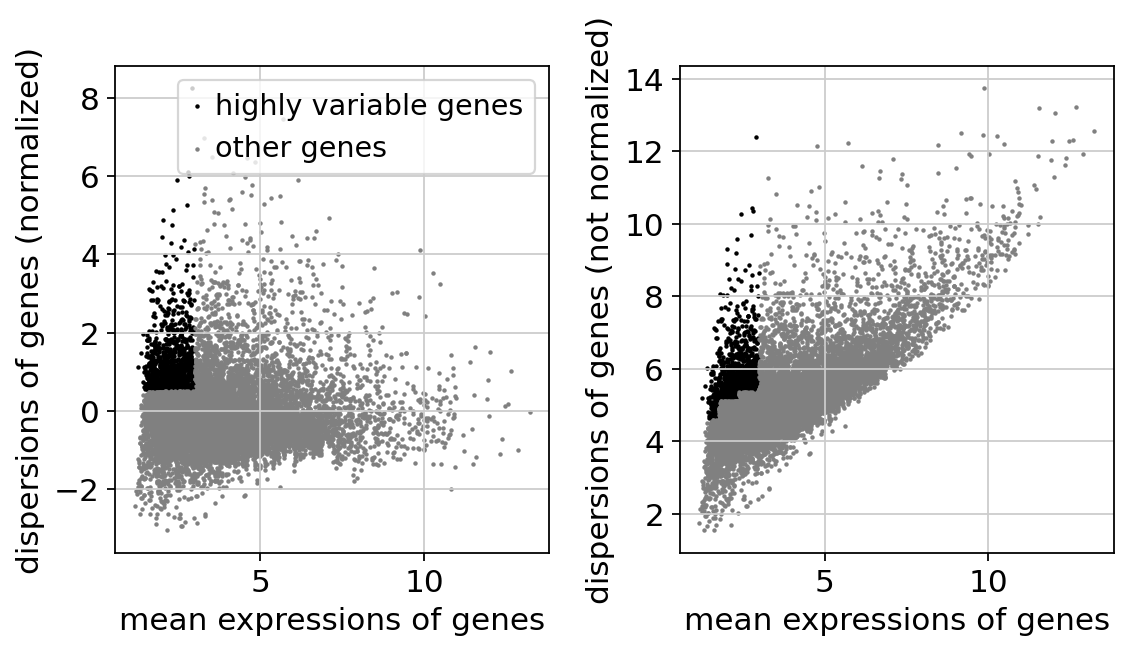

In [8]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:03)


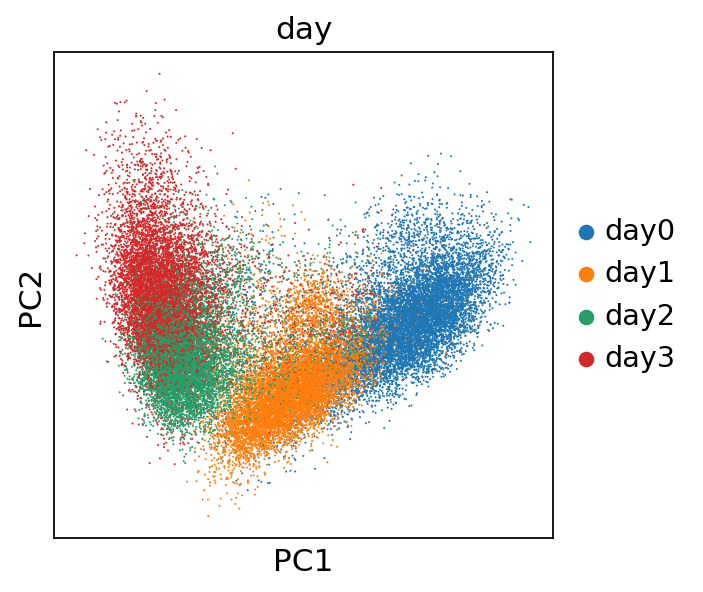

In [9]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable = True)
sc.pl.pca(adata, color='day')

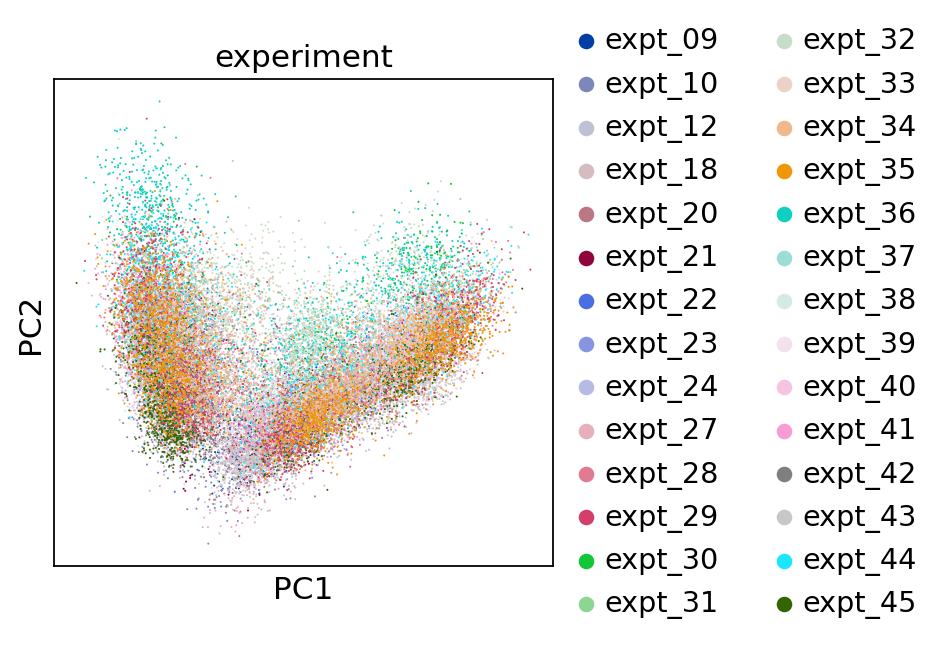

In [10]:
# Visualize the PCA with a few other covariates
sc.pl.pca(adata, color='experiment')

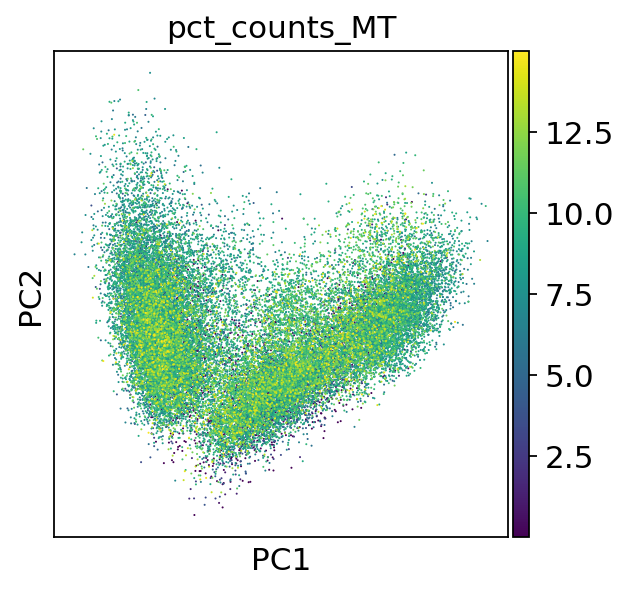

In [11]:
sc.pl.pca(adata, color='pct_counts_MT')

SC Marker

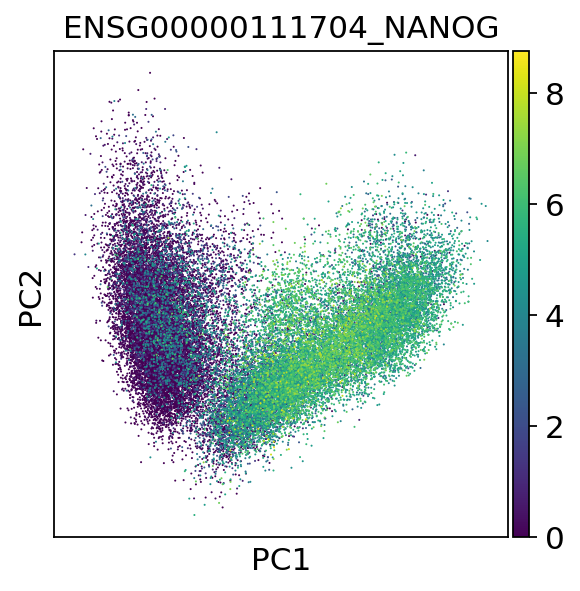

In [12]:
sc.pl.pca(adata, color='ENSG00000111704_NANOG')

Mesoderm Marker

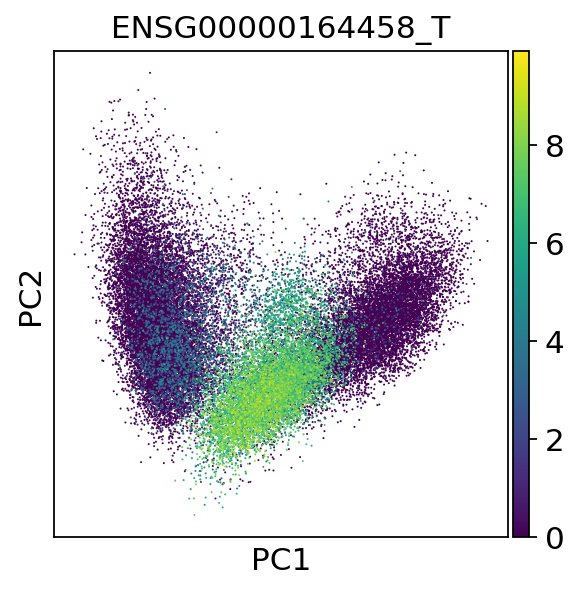

In [12]:
sc.pl.pca(adata, color='ENSG00000164458_T')

Definitive Endoderm Marker

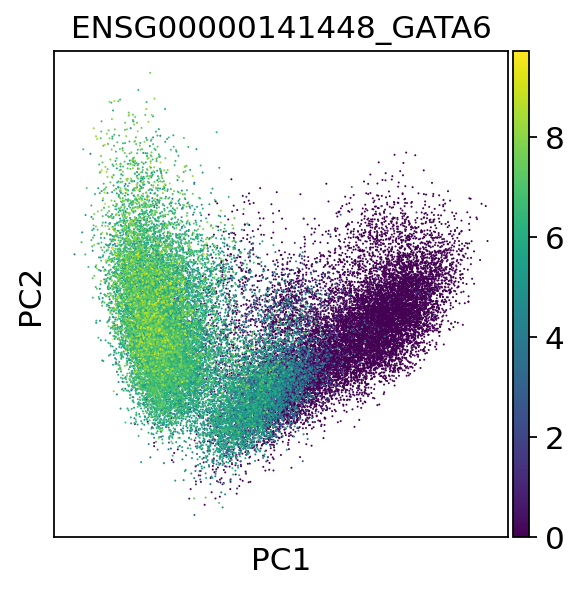

In [13]:
sc.pl.pca(adata, color='ENSG00000141448_GATA6')

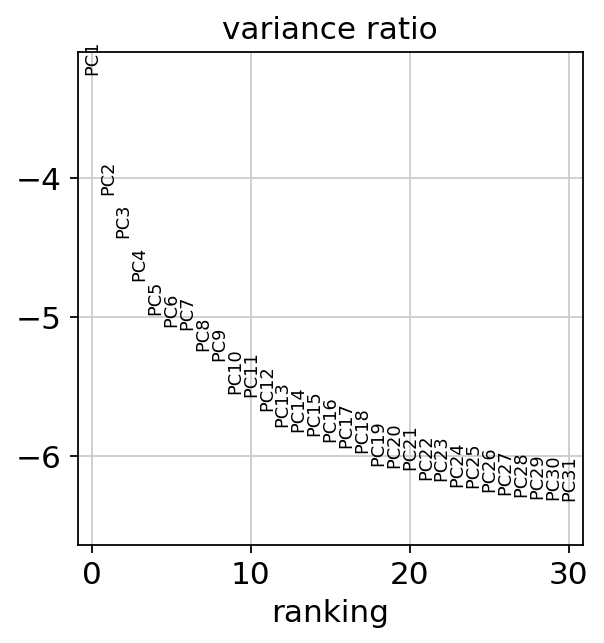

In [14]:
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


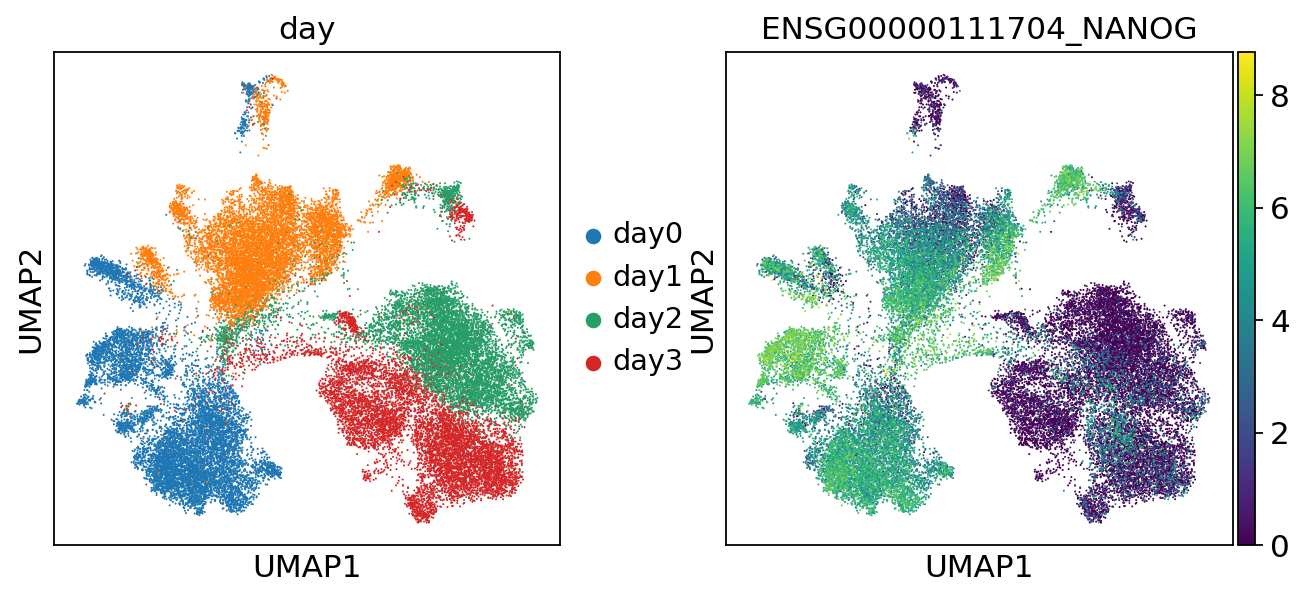

In [16]:
sc.pl.umap(adata, color=['day','ENSG00000111704_NANOG'])

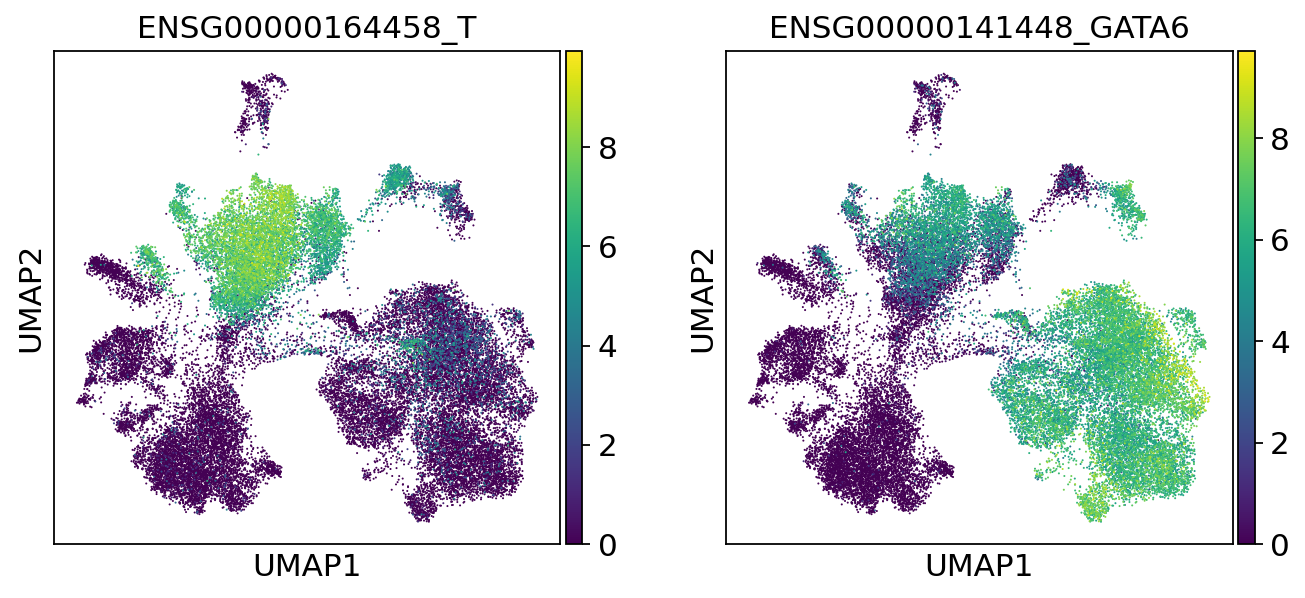

In [18]:
sc.pl.umap(adata, color=['ENSG00000164458_T','ENSG00000141448_GATA6'])

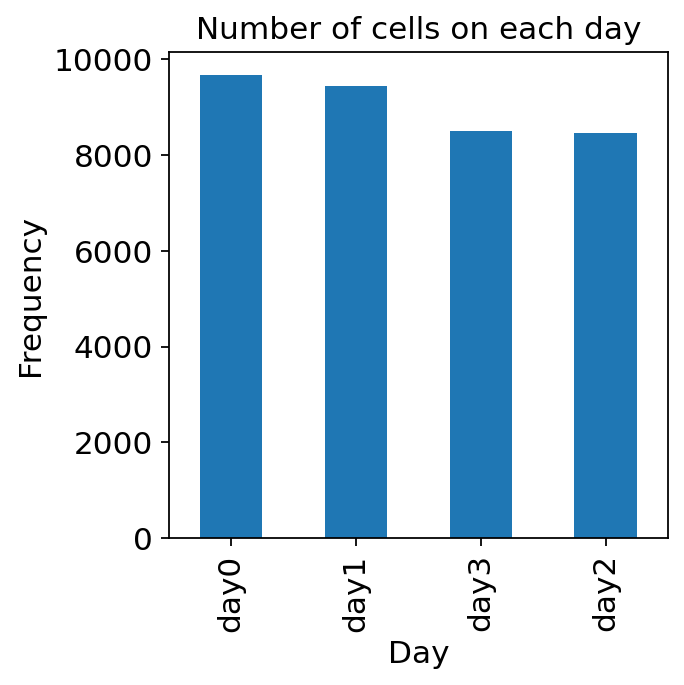

In [13]:
ax = adata.obs['day'].value_counts().plot.bar(title="Number of cells on each day")
_ = ax.set_xlabel('Day')
_ = ax.set_ylabel('Frequency')
ax.grid(False)

In [14]:
PC1_rep = [i[0] for i in adata.obsm['X_pca']]
adata.obs['PC1_rep'] = PC1_rep

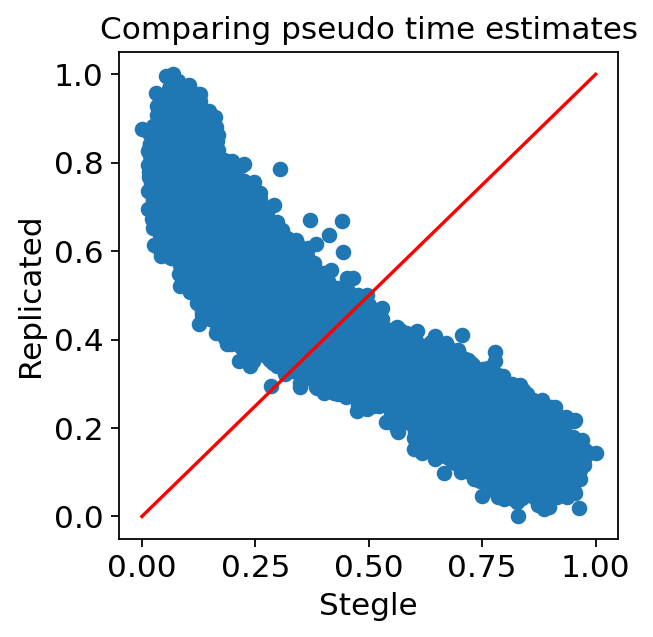

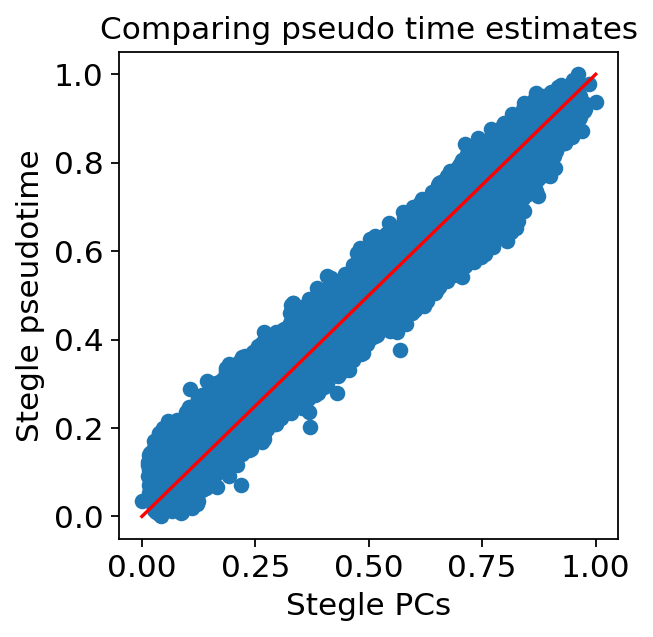

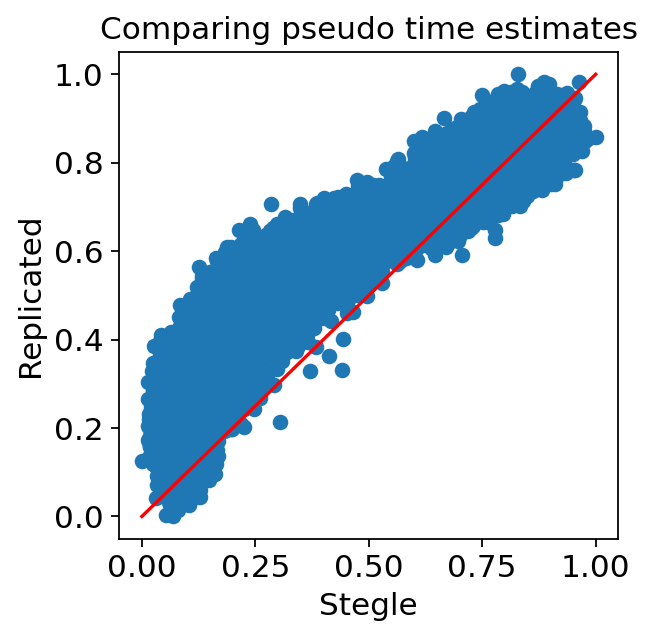

In [15]:
# Compare PCs we compute to the ones in the metadata
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

pl.figure()
pl.scatter(NormalizeData(adata.obs['PC1_top500hvgs']), NormalizeData(adata.obs['PC1_rep']))
pl.grid(b=None)
pl.title("Comparing pseudo time estimates")
pl.xlabel("Stegle")
pl.ylabel("Replicated")
pl.plot( [0,1],[0,1], c = "red")

pl.figure()
pl.scatter(NormalizeData(adata.obs['PC1_top500hvgs']), adata.obs['pseudo'])
pl.grid(b=None)
pl.title("Comparing pseudo time estimates")
pl.xlabel("Stegle PCs")
pl.ylabel("Stegle pseudotime")
pl.plot( [0,1],[0,1], c = "red" )

pl.figure()
pl.scatter(NormalizeData(adata.obs['PC1_top500hvgs']), NormalizeData(-adata.obs['PC1_rep']))
pl.grid(b=None)
pl.title("Comparing pseudo time estimates")
pl.xlabel("Stegle")
pl.ylabel("Replicated")
pl.plot( [0,1],[0,1], c = "red")

In [16]:
# Assign cells to iPSC, 
iPSC = adata[adata.obs['day'] == 'day0'] 
mesendo = adata[adata.obs['day'].str.contains("day1|day2")]
mesendo = mesendo[(mesendo.obs['pseudo'] >= 0.15) & (mesendo.obs['pseudo'] <= 0.5)]
defendo = adata[adata.obs['day'].str.contains("day2|day3")]
defendo = defendo[defendo.obs['pseudo'] >= 0.7]
day1 = adata[adata.obs['day'] == 'day1']
day3 = adata[adata.obs['day'] == 'day3']


In [17]:
print("iPSC")
print(iPSC.n_obs)
print("mesendo")
print(mesendo.n_obs)
print("defendo")
print(defendo.n_obs)
print("Day 1")
print(day1.n_obs)
print("Day 3")
print(day3.n_obs)

iPSC
9661
mesendo
10199
defendo
9906
Day 1
9443
Day 3
8485


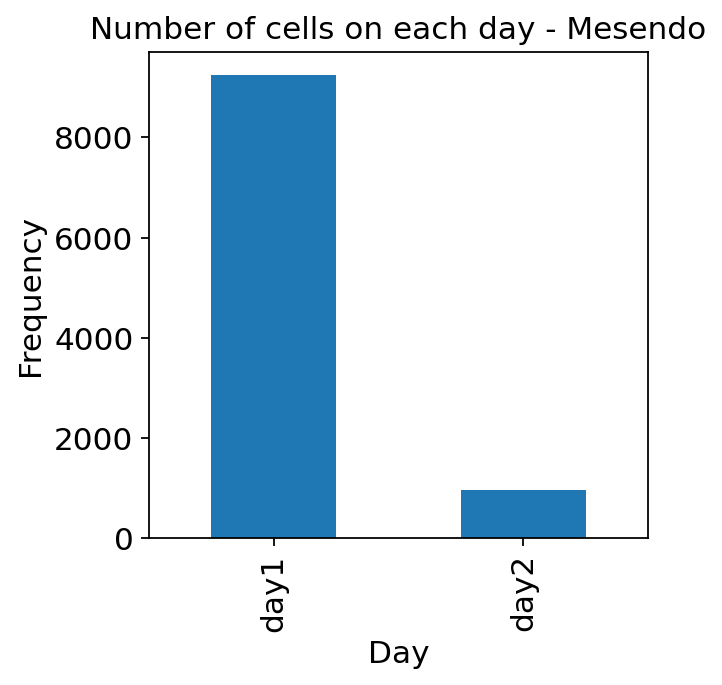

In [18]:
ax = mesendo.obs['day'].value_counts().plot.bar(title="Number of cells on each day - Mesendo")
_ = ax.set_xlabel('Day')
_ = ax.set_ylabel('Frequency')
ax.grid(False)

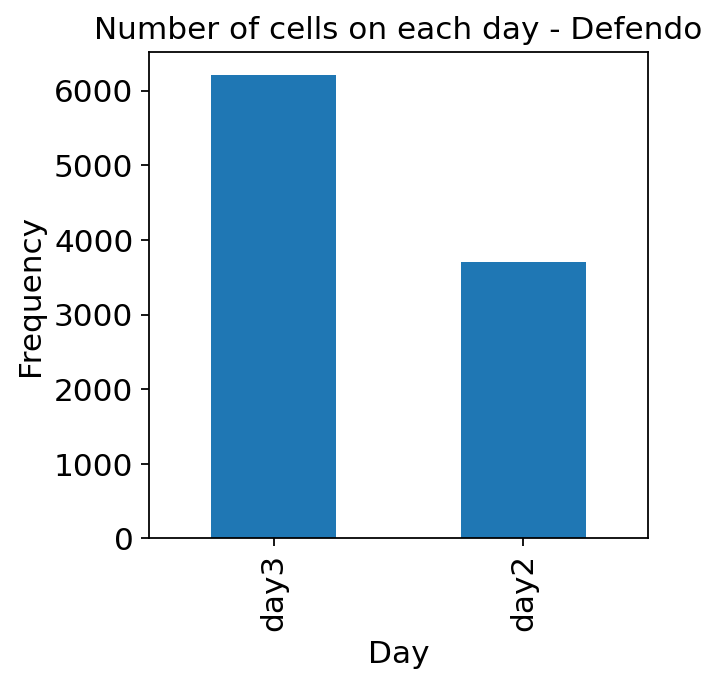

In [25]:
ax = defendo.obs['day'].value_counts().plot.bar(title="Number of cells on each day - Defendo")
_ = ax.set_xlabel('Day')
_ = ax.set_ylabel('Frequency')
ax.grid(False)

In [26]:
pd.DataFrame(data=adata.X, index=adata.obs_names, columns=adata.var_names).to_csv("../data/expr/all_cells.csv")
adata.obs.to_csv("../data/metadata/all_cells.csv")

In [ ]:
sc.write("../data/annData/iPSC.h5ad", iPSC)
sc.write("../data/annData/mesendo.h5ad", mesendo)
sc.write("../data/annData/defendo.h5ad", defendo)
sc.write("../data/annData/all_cells.h5ad", adata)

In [21]:
sc.write("../data/annData/day1.h5ad", day1)
sc.write("../data/annData/day3.h5ad", day3)

In [ ]:
pd.DataFrame(data=iPSC.X, index=iPSC.obs_names, columns=iPSC.var_names).to_csv("../data/expr/iPSC.csv")
pd.DataFrame(data=mesendo.X, index=mesendo.obs_names, columns=mesendo.var_names).to_csv("../data/expr/mesendo.csv")
pd.DataFrame(data=defendo.X, index=defendo.obs_names, columns=defendo.var_names).to_csv("../data/expr/defendo.csv")

In [19]:
pd.DataFrame(data=day1.X, index=day1.obs_names, columns=day1.var_names).to_csv("../data/expr/day1.csv")
pd.DataFrame(data=day3.X, index=day3.obs_names, columns=day3.var_names).to_csv("../data/expr/day3.csv")


In [ ]:
iPSC.obs.to_csv("../data/metadata/iPSC.csv")
mesendo.obs.to_csv("../data/metadata/mesendo.csv")
defendo.obs.to_csv("../data/metadata/defendo.csv")

In [20]:
day1.obs.to_csv("../data/metadata/day1.csv")
day3.obs.to_csv("../data/metadata/day3.csv")